In [31]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

%matplotlib inline

### Define functions 

In [7]:
#General info of the data
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

# Define a function to compute hog features
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, feature_vec=True):

    features = hog(img, orientations=orient,
                   pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block),
                   transform_sqrt=True, feature_vector=feature_vec)
    
    return features

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
  
    return hist_features


def convert_color(img, color_space='YCrCb'):
    if color_space == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        
    return feature_image

def single_img_features(img, color_space='YCrCb', spatial_size=(32, 32), hist_bins=32, 
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []

    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = convert_color(img, color_space=color_space)
    else: feature_image = np.copy(img)

    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)

    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)

    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                    feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, feature_vec=True)
       
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)



def prepare_features(cars=[],notcars=[],color_space='YCrCb',spatial_size=(32,32),hist_bins=32,
                    orient=9,pix_per_cell=8,cell_per_block=2,hog_channel='ALL',
                    spatial_f=True,hist_f=True,hog_f=True):

    car_features = []
    for file in cars:
        image = mpimg.imread(file)
        feature = single_img_features(image, color_space=color_space, spatial_size=spatial_size, 
                                      hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, hog_channel=hog_channel,
                                      spatial_feat=spatial_f, hist_feat=hist_f, hog_feat=hog_f)        
        car_features.append(feature)
        
    notcar_features = []
    for file in notcars:
        image = mpimg.imread(file)
        feature = single_img_features(image, color_space=color_space, spatial_size=spatial_size, 
                                      hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, hog_channel=hog_channel,
                                      spatial_feat=spatial_f, hist_feat=hist_f, hog_feat=hog_f)        
        notcar_features.append(feature)
        


    #Combine features together
    car_features = np.array(car_features)
    notcar_features = np.array(notcar_features)


    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


    return X_train, X_test, y_train, y_test, X_scaler


def train_svc_model(X_train=[], X_test=[], y_train=[], y_test=[]):
    # Use a linear SVC
    svc = LinearSVC()    
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

    return svc


### Training a svm model 

In [9]:
####Load training data
######################
car_images1 = glob.glob('vehicles/GTI*/*.png')
car_images2 = glob.glob('vehicles/KITTI*/*.png')
notcar_images1 = glob.glob('non-vehicles/GTI/*.png')
notcar_images2 = glob.glob('non-vehicles/Extras/*.png')
cars = []
notcars = []

for image in car_images1:
    cars.append(image)
for image in car_images2:
    cars.append(image)

for image in notcar_images1:
    notcars.append(image)
for image in notcar_images2:
    notcars.append(image)

#Get summary of training data
data_info = data_look(cars, notcars)

print('Your function returned a count of',
      data_info["n_cars"], ' cars and',
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:',
      data_info["data_type"])

####Prepare feature data
########################
print('prepare feature data...')

# Set up parameters
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial = (32,32)  #64
hist_bins = 32 #64
orient = 9 #18
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

X_train, X_test, y_train, y_test, X_scaler = prepare_features(cars=cars,notcars=notcars,\
                                    color_space=colorspace,spatial_size=spatial,hist_bins=hist_bins,\
                                    orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,\
                                    hog_channel=hog_channel)

print('Feature vector length:', len(X_train[0]))


####Training
############
print('training...')
svc = train_svc_model(X_train=X_train, X_test=X_test, \
                            y_train=y_train, y_test=y_test)



Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32
prepare feature data...
Feature vector length: 8460
training...
5.06 Seconds to train SVC...
Test Accuracy of SVC =  0.9907


### Sliding window search 

In [73]:
def find_cars(img, ystart, ystop, scale, cells_per_step, svc, X_scaler, orient, pix_per_cell, \
                cell_per_block, spatial_size, hist_bins, hog_channel):

    draw_img = np.copy(img)

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space='YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1
    cells_per_step = cells_per_step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            elif hog_channel == 0:
                hog_features = hog_feat1
            elif hog_channel == 1:
                hog_features = hog_feat2
            else:
                hog_features = hog_feat3


            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, \
                                                          hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),\
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return draw_img, box_list


- Test on single images

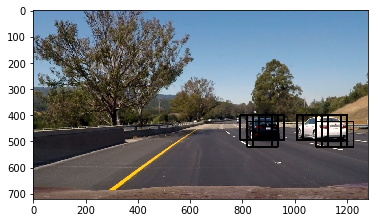

In [91]:
image = mpimg.imread('test_images/test6.jpg')

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

ystart = 400
ystop = 656
scale = 1.5
cells_per_step = 2
out_img, box_list = find_cars(image, ystart, ystop, scale, cells_per_step, svc, X_scaler, orient, pix_per_cell, \
                cell_per_block, spatial, hist_bins, hog_channel)

plt.imshow(out_img)
plt.show()
mpimg.imsave('test6_findcars.jpg', out_img)

### Multiple detection and false positives 

In [92]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Pipeline on images 

Performance on test images:


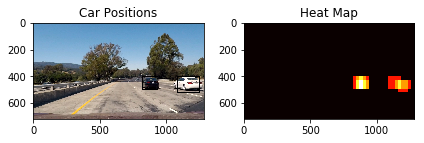

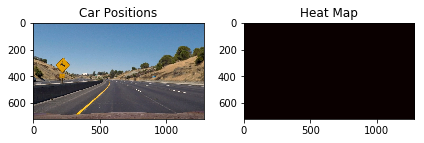

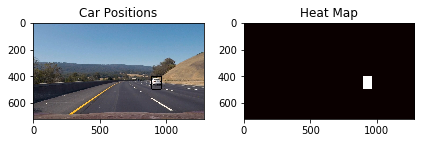

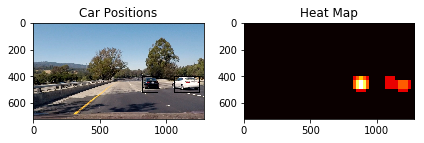

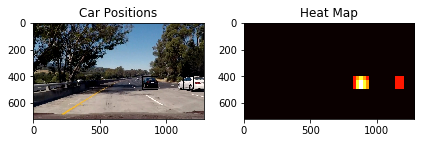

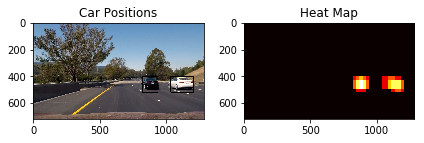

In [93]:
####Find cars for test image
############################
print('Performance on test images:')

images = glob.glob('./test_images/test*.jpg')

for img_name in images:
    image = mpimg.imread(img_name)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    ystart = 400
    ystop = 656
    scale = 1.5
    cells_per_step = 2
    out_img, box_list = find_cars(image, ystart, ystop, scale, cells_per_step, \
                                  svc, X_scaler, orient, pix_per_cell, \
                                  cell_per_block, spatial, hist_bins, hog_channel)
    

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    out_name = img_name.split('/')[2].split('.')[0]
    out_name = out_name + '_out.jpg'
    mpimg.imsave(out_name, draw_img)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()


### Pipeline on video 

In [94]:
def process_image(image):
    
    image0 = np.copy(image)
    image = image.astype(np.float32)/255

    ystart = 400
    ystop = 656
    scale = 1.5
    cells_per_step = 2
    out_img, box_list = find_cars(image, ystart, ystop, scale, cells_per_step, \
                                  svc, X_scaler, orient, pix_per_cell, \
                                  cell_per_block, spatial, hist_bins, hog_channel)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image0), labels)
    
    return draw_img

In [95]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_video_out.mp4'
clip1 = VideoFileClip("test_video.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:11<00:00,  3.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 11.1 s, sys: 733 ms, total: 11.8 s
Wall time: 12.4 s


In [51]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [05:36<00:00,  3.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 5min 23s, sys: 18.2 s, total: 5min 41s
Wall time: 5min 37s
